In [133]:
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

In [134]:
wandb.login()

True

In [135]:
api = wandb.Api()
sweep_ids = ["1qcd2x0p", "dwqldmag", "s3jg6oju", "cw2quf1k", "68wrws1j", "11su7p2g"]
# sweep_ids = ["68wrws1j", "11su7p2g"]
sweeps = [api.sweep(f"eraldoluis/WeightedCRF/{sweep_id}") for sweep_id in sweep_ids]

In [136]:
runs = [run for sweep in sweeps for run in sweep.runs]
# run = next(runs)
# next(run.scan_history(keys=["model.label_weights.O", "validation/macro-fscore"]))
len(runs)

483

In [137]:
import pandas as pd 
# import wandb
# api = wandb.Api()

# # Project is specified by <entity/project-name>
# runs = api.runs("eraldoluis/WeightedCRF")

tags = ["O", "PER", "LOC", "ORG", "MISC"]

# columns to select
cols = ["name", "model.label_weights", "_step"]
cols += [f"validation/macro-{m}" for m in ["fscore", "precision", "recall"]]
cols += [f"validation/{tag}-{m}" for tag in tags for m in ["fscore", "precision", "recall"]]

values = []
for run in runs: 
    # .name is the human-readable name of the run.
    val = {"name": run.name}

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # val.update({
    #     k: v for k, v in run.config.items() 
    #         if not k.startswith('_') and "label_weights" in k})
    val.update({k: v for k, v in run.config.items() if k in cols})

    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    # val.update({k: v for k, v in run.summary._json_dict.items() if k in cols})

    for hist in run._full_history():
    # for hist in run._sampled_history(["step"]):
        val_ = val.copy()
        val_.update({k: v for k, v in hist.items() if k in cols})
        values.append(val_)

runs_df = pd.DataFrame(values, columns=cols)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [138]:
runs_df.head(5)

,name,model.label_weights,_step,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,validation/O-precision,validation/O-recall,validation/PER-fscore,...,validation/PER-recall,validation/LOC-fscore,validation/LOC-precision,validation/LOC-recall,validation/ORG-fscore,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall
0,crimson-sweep-20,{'MISC': 1.2},14,0.181486,0.167277,0.199090,0.906580,0.832612,0.994972,0.000000,...,0.000000,0.000848,0.003774,0.000478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,crimson-sweep-20,{'MISC': 1.2},28,0.181642,0.167573,0.199399,0.907339,0.832812,0.996515,0.000000,...,0.000000,0.000873,0.005051,0.000478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,crimson-sweep-20,{'MISC': 1.2},42,0.237205,0.361046,0.244506,0.915762,0.857402,0.982647,0.023559,...,0.012067,0.205496,0.205643,0.205349,0.041210,0.248677,0.022467,0.000000,0.000000,0.000000
3,crimson-sweep-20,{'MISC': 1.2},56,0.409789,0.451058,0.402580,0.970096,0.948474,0.992727,0.358983,...,0.338520,0.491329,0.495627,0.487106,0.199254,0.225030,0.178776,0.029283,0.204082,0.015773
4,crimson-sweep-20,{'MISC': 1.2},70,0.495627,0.536128,0.524673,0.986032,0.978314,0.993873,0.647722,...,0.738330,0.606299,0.515740,0.735435,0.115811,0.411079,0.067400,0.122271,0.198582,0.088328


In [139]:
base_dict = {k: 1.0 for k in tags}
def transf(w):
    new_d = dict(base_dict)
    new_d.update(w)
    new_d = {f"label_weight_{k}": v for k, v in new_d.items()}
    return pd.Series(new_d)

df_runs_weights = pd.concat([runs_df, runs_df["model.label_weights"].apply(transf)], axis=1)

In [140]:
df_runs_weights.sample(5)

,name,model.label_weights,_step,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,validation/O-precision,validation/O-recall,validation/PER-fscore,...,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall,label_weight_O,label_weight_PER,label_weight_LOC,label_weight_ORG,label_weight_MISC
9749,restful-sweep-86,{'PER': 1.2},84,0.513772,0.619548,0.511020,0.975863,0.957300,0.995159,0.539150,...,0.535977,0.348948,0.070278,0.489796,0.037855,1.0,1.2,1.0,1.0,1.0
12098,neat-sweep-1,{'O': 0.8},42,0.182081,0.193173,0.200140,0.908507,0.832532,0.999743,0.000000,...,0.133333,0.000956,0.000000,0.000000,0.000000,0.8,1.0,1.0,1.0,1.0
12607,fast-sweep-32,{'LOC': 1.5},100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.5,1.0,1.0
2538,different-sweep-18,{'O': 0.8},238,0.247229,0.342380,0.248198,0.918762,0.851614,0.997404,0.022910,...,0.403494,0.231836,0.000000,0.000000,0.000000,0.8,1.0,1.0,1.0,1.0
8464,dauntless-sweep-132,{'ORG': 1.2},112,0.718956,0.732748,0.713761,0.991568,0.988995,0.994153,0.800485,...,0.680611,0.489962,0.452973,0.486854,0.423502,1.0,1.0,1.0,1.2,1.0


In [141]:
sels = [df_runs_weights[f"label_weight_{tag}"] == 1.0 for tag in tags]
for i, s in enumerate(sels):
    print(f"{tags[i]}: {len(s) - s.sum()}")

O: 2548
PER: 2744
LOC: 2744
ORG: 2240
MISC: 2240


In [142]:
import numpy as np
def get_sel(idx):
    sels_diff = [s for i, s in enumerate(sels) if i != idx]
    sels_diff_and = sels_diff[0]
    for s in sels_diff[1:]:
        sels_diff_and = (sels_diff_and & s)
    return df_runs_weights[sels_diff_and]

In [143]:
max_step = df_runs_weights["_step"].max()

In [144]:
import numpy as np
def get_sel_max_step(idx):
    sels_diff = [s for i, s in enumerate(sels) if i != idx]
    sels_diff.append(df_runs_weights["_step"] == max_step)
    sels_diff_and = sels_diff[0]
    for s in sels_diff[1:]:
        sels_diff_and = (sels_diff_and & s)
    return df_runs_weights[sels_diff_and]

In [147]:
def plot_metrics_max_step(tag):
    value_cols = [
        "validation/macro-fscore", 
        f"validation/{tags[tag]}-fscore",
        f"validation/{tags[tag]}-precision",
        f"validation/{tags[tag]}-recall"
    ]
    df = get_sel_max_step(tag).melt(id_vars=[f"label_weight_{tags[tag]}"], value_vars=value_cols)
    sns.lineplot(data=df, x=f"label_weight_{tags[tag]}", y="value", hue="variable")

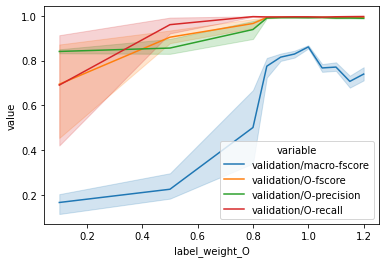

In [148]:
plot_metrics_max_step(0)

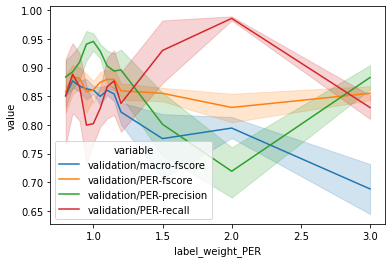

In [149]:
plot_metrics_max_step(1)

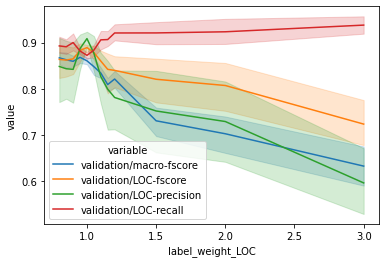

In [150]:
plot_metrics_max_step(2)

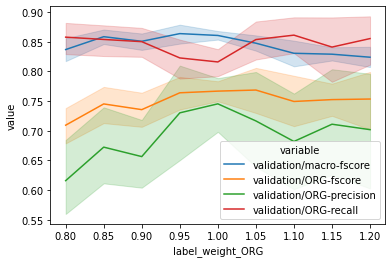

In [151]:
plot_metrics_max_step(3)

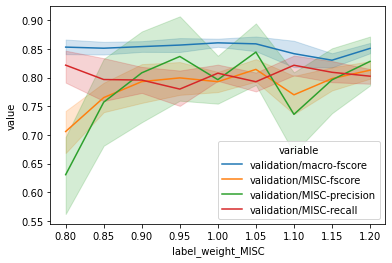

In [152]:
plot_metrics_max_step(4)